<a href="https://colab.research.google.com/github/armelida/MELIDA/blob/main/notebooks/prompting_strategy_evaluator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1: Check Runtime & GPU Availability
import torch
import os
import subprocess

def check_runtime():
    """Check whether a GPU or TPU is available."""
    if torch.cuda.is_available():
        gpu_name = torch.cuda.get_device_name(0)
        print(f"✅ GPU is enabled! Using: {gpu_name}")
    elif "COLAB_TPU_ADDR" in os.environ:
        print("✅ TPU is enabled!")
    else:
        print("⚠️ WARNING: No GPU or TPU detected. Running on CPU.")
        print("👉 Go to Runtime > Change runtime type > Select GPU/TPU")

def check_gpu():
    """Check GPU details using nvidia-smi if available."""
    try:
        result = subprocess.run(
            ["nvidia-smi"], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True
        )
        if result.returncode == 0:
            print(result.stdout)
        else:
            print("⚠️ `nvidia-smi` not found. No GPU detected.")
    except FileNotFoundError:
        print("⚠️ No GPU found.")

# Run the checks
check_runtime()
check_gpu()


✅ GPU is enabled! Using: NVIDIA A100-SXM4-40GB
Mon Mar 17 22:41:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             42W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+

In [2]:
# Cell 2: Clone Repository & Install Requirements
# Remove any existing directory and clone a fresh copy of MELIDA.
!rm -rf MELIDA
!git clone https://github.com/armelida/MELIDA.git
%cd MELIDA
!pip install -r requirements.txt


Cloning into 'MELIDA'...
remote: Enumerating objects: 212, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 212 (delta 4), reused 1 (delta 1), pack-reused 205 (from 1)
Receiving objects: 100% (212/212), 174.72 KiB | 14.56 MiB/s, done.
Resolving deltas: 100% (103/103), done.
/content/MELIDA


In [3]:
# Cell 3: Setup Configuration & Fetch Prompt Strategies
import os
import json
import requests

# Create config directory if it does not exist
os.makedirs('config', exist_ok=True)

def fetch_prompt_strategies(url):
    """Fetch prompt strategies JSON from GitHub and add extra metadata."""
    print(f"Fetching prompt strategies from GitHub: {url}")
    try:
        response = requests.get(url)
        response.raise_for_status()
        strategies = response.json()
        print(f"✓ Loaded {len(strategies)} prompt strategies.")

        # Enrich each strategy with language and tags if missing
        for strategy in strategies.values():
            if "language" not in strategy:
                desc = strategy.get("description", "")
                if "Spanish" in desc:
                    strategy["language"] = "Spanish"
                elif "English" in desc:
                    strategy["language"] = "English"
                else:
                    strategy["language"] = "Unknown"
            if "tags" not in strategy:
                strategy["tags"] = []
                if "doctor" in strategy.get("description", "").lower():
                    strategy["tags"].append("doctor_role")
                if "reasoning" in strategy.get("description", "").lower():
                    strategy["tags"].append("reasoning")
                if "confidence" in strategy.get("description", "").lower():
                    strategy["tags"].append("confidence")
        return strategies
    except Exception as e:
        print(f"Error: {e}\nUsing default prompt strategies instead.")
        # Default prompt strategies as fallback
        return {
            "Prompt-001": {
                "description": "Basic prompt for test-taking",
                "template": ("Answer the following question:\n\n{question_text}\n\n"
                             "A) {option_a}\nB) {option_b}\nC) {option_c}\nD) {option_d}\n\n"
                             "Your answer (only A, B, C, D):")
            }
        }

github_url = "https://raw.githubusercontent.com/armelida/MELIDA/main/config/prompt_strategies.json"
prompt_strategies = fetch_prompt_strategies(github_url)

# Validate required placeholders in each strategy
required_placeholders = ["{question_text}", "{option_a}", "{option_b}", "{option_c}", "{option_d}"]
for sid, strategy in prompt_strategies.items():
    template = strategy.get("template", "")
    missing = [ph for ph in required_placeholders if ph not in template]
    if missing:
        print(f"Warning: Strategy {sid} is missing placeholders: {', '.join(missing)}")

# Save the strategies locally
with open('config/prompt_strategies.json', 'w') as f:
    json.dump(prompt_strategies, f, indent=2)
print("✓ Prompt strategies saved to config/prompt_strategies.json")


Fetching prompt strategies from GitHub: https://raw.githubusercontent.com/armelida/MELIDA/main/config/prompt_strategies.json
✓ Loaded 2 prompt strategies.
✓ Prompt strategies saved to config/prompt_strategies.json


In [4]:
# Cell 4: Load API Keys & Save API Configuration
!pip install python-dotenv
import os
from dotenv import load_dotenv
!pip install python-dotenv

# Initialize API keys dictionary
api_keys = {"openai": None, "anthropic": None}

# Try to load from Colab secrets (if available)
try:
    from google.colab import userdata
    api_keys["openai"] = userdata.get('OPENAI_API_KEY')
    api_keys["anthropic"] = userdata.get('ANTHROPIC_API_KEY')
    if api_keys["openai"] and api_keys["anthropic"]:
        print("✓ API keys loaded from Colab secrets")
except Exception as e:
    print(f"Note: Couldn't load from Colab secrets - {e}")

# Fallback: load from environment variables
if not all(api_keys.values()):
    api_keys["openai"] = api_keys["openai"] or os.environ.get("OPENAI_API_KEY")
    api_keys["anthropic"] = api_keys["anthropic"] or os.environ.get("ANTHROPIC_API_KEY")
    if api_keys["openai"] or api_keys["anthropic"]:
        print("✓ API keys loaded from environment variables")

# Fallback: load from a .env file
if not all(api_keys.values()):
    try:
        load_dotenv()
        api_keys["openai"] = api_keys["openai"] or os.environ.get("OPENAI_API_KEY")
        api_keys["anthropic"] = api_keys["anthropic"] or os.environ.get("ANTHROPIC_API_KEY")
        if api_keys["openai"] or api_keys["anthropic"]:
            print("✓ API keys loaded from .env file")
    except Exception as e:
        print(f"Note: Couldn't load from .env file - {e}")

# Propagate keys to os.environ so subsequent cells can access them
if api_keys["openai"]:
    os.environ["OPENAI_API_KEY"] = api_keys["openai"]
if api_keys["anthropic"]:
    os.environ["ANTHROPIC_API_KEY"] = api_keys["anthropic"]

# Create and save API configuration
api_config = {
    "openai": {"api_key": api_keys["openai"] or "YOUR_OPENAI_API_KEY_HERE"},
    "anthropic": {"api_key": api_keys["anthropic"] or "YOUR_ANTHROPIC_API_KEY_HERE"}
}
with open('config/api_config.json', 'w') as f:
    json.dump(api_config, f, indent=2)

if api_keys["openai"] and api_keys["anthropic"]:
    print("✓ Complete API configuration saved")
else:
    missing = []
    if not api_keys["openai"]:
        missing.append("OpenAI")
    if not api_keys["anthropic"]:
        missing.append("Anthropic")
    print(f"⚠ Missing API keys: {', '.join(missing)}")
    print("Please set the API keys using one of the available methods.")


✓ API keys loaded from Colab secrets
✓ Complete API configuration saved


In [5]:
# Cell 5: Data Loading & Standardization (Updated)
import json
import os

print("\n--- Data Loading ---")
questions_file = 'data/questions/MIR-2024-v01-t01.json'
answers_file = 'data/answers/MIR-2024-v01-t01-answers.json'

# Ensure the questions directory exists (it should, but just in case)
os.makedirs(os.path.dirname(questions_file), exist_ok=True)

# Load questions
with open(questions_file, 'r', encoding='utf-8') as f:
    questions = json.load(f)
print(f"✓ Loaded {len(questions)} questions from {questions_file}")

# Convert the list of questions to a dictionary keyed by question ID if needed
if isinstance(questions, list):
    questions = {q['id']: q for q in questions}
    print("✓ Converted questions list to a dictionary keyed by question ID")

    # Save the converted questions back to disk in the same folder
    dict_questions_file = 'data/questions/MIR-2024-v01-t01-dict.json'
    with open(dict_questions_file, 'w', encoding='utf-8') as f:
        json.dump(questions, f, indent=2)
    print(f"✓ Saved converted questions to {dict_questions_file}")

# Load answers (assumed as a dictionary)
with open(answers_file, 'r', encoding='utf-8') as f:
    answers_dict = json.load(f)
print(f"✓ Loaded answers from {answers_file}")

# Convert answers dictionary to list format for the evaluator
answers = [{"id": qid, "correct_option": ans} for qid, ans in answers_dict.items()]
print(f"✓ Converted answers to list format with {len(answers)} items")

# Save standardized answers for the evaluator
std_answers_file = 'data/answers/MIR-2024-v01-t01-answers-standardized.json'
with open(std_answers_file, 'w', encoding='utf-8') as f:
    json.dump(answers, f, indent=2)
print(f"✓ Standardized answers saved to {std_answers_file}")

# Check for matching question IDs and answer IDs
question_ids = set(questions.keys())
answer_ids = {a['id'] for a in answers}
matched = question_ids.intersection(answer_ids)
print(f"✓ Found {len(matched)} matching questions out of {len(question_ids)} total questions")



--- Data Loading ---
✓ Loaded 174 questions from data/questions/MIR-2024-v01-t01.json
✓ Converted questions list to a dictionary keyed by question ID
✓ Saved converted questions to data/questions/MIR-2024-v01-t01-dict.json
✓ Loaded answers from data/answers/MIR-2024-v01-t01-answers.json
✓ Converted answers to list format with 174 items
✓ Standardized answers saved to data/answers/MIR-2024-v01-t01-answers-standardized.json
✓ Found 174 matching questions out of 174 total questions


In [6]:
# Cell 6: Run Sample Evaluation (Using Provided Prompt-001)
import json
from src.evaluator import ModelEvaluator

# Define parameters:
# Using two models:
#  - OpenAI reasoning model "o3-mini-2025-01-31"
#  - Anthropic model "claude-3-7-sonnet-20250219"
models_to_test = ['o3-mini-2025-01-31', 'claude-3-7-sonnet-20250219']

# We use Prompt-001 from your prompt strategies file
prompt_strategy = "Prompt-001"
sample_size = 5  # Evaluate 5 questions per model

# Use the original questions file (list format) and answer key file (dictionary format)
questions_file = 'data/questions/MIR-2024-v01-t01.json'
answer_key_file = 'data/answers/MIR-2024-v01-t01-answers.json'

# Initialize the evaluator
evaluator = ModelEvaluator()

print("\n--- RUNNING SAMPLE EVALUATION ---")
results_summary = {}

# Loop through each model and run a sample evaluation with sample_size = 5
for model in models_to_test:
    print(f"\nEvaluating Model: {model} using Prompt Strategy: {prompt_strategy}")
    try:
        # run_evaluation uses the prompt from Prompt-001
        result_file = evaluator.run_evaluation(
            questions_file=questions_file,
            answer_key_file=answer_key_file,
            prompt_strategy=prompt_strategy,
            model=model,
            sample_size=sample_size
        )
        print(f"✓ Sample evaluation complete for {model}. Results saved to: {result_file}")

        # Load and display the summary of the evaluation results
        with open(result_file, 'r') as f:
            results = json.load(f)
        summary = results.get('summary', {})
        results_summary[model] = summary

        print("\n--- SAMPLE EVALUATION RESULTS ---")
        print(f"Model: {summary.get('model', 'N/A')}")
        print(f"Prompt Strategy: {summary.get('prompt_strategy', 'N/A')}")
        print(f"Total Questions: {summary.get('total_questions', 'N/A')}")
        print(f"Correct Answers: {summary.get('correct_count', 'N/A')} ({summary.get('accuracy', 0)*100:.2f}%)")
        print(f"Incorrect Answers: {summary.get('incorrect_count', 'N/A')}")
        print(f"Skipped Questions: {summary.get('skipped_count', 'N/A')}")
        print(f"Invalid Count: {summary.get('invalid_count', 'N/A')}")
        print(f"Total Score: {summary.get('total_score', 'N/A')}")
    except Exception as e:
        print(f"✗ Error during sample evaluation for {model}: {e}")

print("\nIf the sample evaluation looks good, proceed to full evaluation in the next cell.")



--- RUNNING SAMPLE EVALUATION ---

Evaluating Model: o3-mini-2025-01-31 using Prompt Strategy: Prompt-001


Evaluating questions: 100%|██████████| 5/5 [00:25<00:00,  5.09s/it]


✓ Sample evaluation complete for o3-mini-2025-01-31. Results saved to: data/results/EVAL-MIR-2024-v01-t01-Prompt-001-o3-mini-2025-01-31-20250317-224252.json

--- SAMPLE EVALUATION RESULTS ---
Model: o3-mini-2025-01-31
Prompt Strategy: Prompt-001
Total Questions: 5
Correct Answers: 5 (100.00%)
Incorrect Answers: 0
Skipped Questions: 0
Invalid Count: 0
Total Score: 15

Evaluating Model: claude-3-7-sonnet-20250219 using Prompt Strategy: Prompt-001


Evaluating questions: 100%|██████████| 5/5 [00:09<00:00,  1.83s/it]

✓ Sample evaluation complete for claude-3-7-sonnet-20250219. Results saved to: data/results/EVAL-MIR-2024-v01-t01-Prompt-001-claude-3-7-sonnet-20250219-20250317-224301.json

--- SAMPLE EVALUATION RESULTS ---
Model: claude-3-7-sonnet-20250219
Prompt Strategy: Prompt-001
Total Questions: 5
Correct Answers: 5 (100.00%)
Incorrect Answers: 0
Skipped Questions: 0
Invalid Count: 0
Total Score: 15

If the sample evaluation looks good, proceed to full evaluation in the next cell.


In [8]:
# Cell 7: Run Full Evaluation
import os
import json
from src.evaluator import ModelEvaluator

# Define parameters:
models_to_test = ['o3-mini-2025-01-31', 'claude-3-7-sonnet-20250219']
prompt_strategies_to_test = [f'Prompt-{i:03d}' for i in range(1, 11)]

# Use the original questions file and answer key file (as expected by the evaluator)
questions_file = 'data/questions/MIR-2024-v01-t01.json'
answer_key_file = 'data/answers/MIR-2024-v01-t01-answers.json'

# Initialize the evaluator
evaluator = ModelEvaluator()

result_files = []

print("\n--- RUNNING FULL EVALUATION ---")
for model in models_to_test:
    for prompt_strategy in prompt_strategies_to_test:
        print(f"\nEvaluating Model: {model} | Prompt Strategy: {prompt_strategy}")
        try:
            result_file = evaluator.run_evaluation(
                questions_file=questions_file,
                answer_key_file=answer_key_file,
                prompt_strategy=prompt_strategy,
                model=model,
                sample_size=None  # Use all questions
            )
            result_files.append(result_file)
            print(f"✓ Evaluation complete. Results saved to: {result_file}")
        except Exception as e:
            print(f"✗ Error during evaluation for Model: {model} | Prompt: {prompt_strategy} --> {e}")

print(f"\n--- FULL EVALUATION COMPLETE ---")
print(f"Generated {len(result_files)} result files")

# Optionally, list out the generated result files
for rf in result_files:
    print(rf)



--- RUNNING FULL EVALUATION ---

Evaluating Model: o3-mini-2025-01-31 | Prompt Strategy: Prompt-001


Evaluating questions: 100%|██████████| 174/174 [12:13<00:00,  4.22s/it]


✓ Evaluation complete. Results saved to: data/results/EVAL-MIR-2024-v01-t01-Prompt-001-o3-mini-2025-01-31-20250317-225634.json

Evaluating Model: o3-mini-2025-01-31 | Prompt Strategy: Prompt-002


Evaluating questions: 100%|██████████| 174/174 [12:22<00:00,  4.26s/it]


✓ Evaluation complete. Results saved to: data/results/EVAL-MIR-2024-v01-t01-Prompt-002-o3-mini-2025-01-31-20250317-230856.json

Evaluating Model: o3-mini-2025-01-31 | Prompt Strategy: Prompt-003


Evaluating questions:   0%|          | 0/174 [00:00<?, ?it/s]


✗ Error during evaluation for Model: o3-mini-2025-01-31 | Prompt: Prompt-003 --> 'Prompt-003'

Evaluating Model: o3-mini-2025-01-31 | Prompt Strategy: Prompt-004


Evaluating questions:   0%|          | 0/174 [00:00<?, ?it/s]


✗ Error during evaluation for Model: o3-mini-2025-01-31 | Prompt: Prompt-004 --> 'Prompt-004'

Evaluating Model: o3-mini-2025-01-31 | Prompt Strategy: Prompt-005


Evaluating questions:   0%|          | 0/174 [00:00<?, ?it/s]


✗ Error during evaluation for Model: o3-mini-2025-01-31 | Prompt: Prompt-005 --> 'Prompt-005'

Evaluating Model: o3-mini-2025-01-31 | Prompt Strategy: Prompt-006


Evaluating questions:   0%|          | 0/174 [00:00<?, ?it/s]


✗ Error during evaluation for Model: o3-mini-2025-01-31 | Prompt: Prompt-006 --> 'Prompt-006'

Evaluating Model: o3-mini-2025-01-31 | Prompt Strategy: Prompt-007


Evaluating questions:   0%|          | 0/174 [00:00<?, ?it/s]


✗ Error during evaluation for Model: o3-mini-2025-01-31 | Prompt: Prompt-007 --> 'Prompt-007'

Evaluating Model: o3-mini-2025-01-31 | Prompt Strategy: Prompt-008


Evaluating questions:   0%|          | 0/174 [00:00<?, ?it/s]


✗ Error during evaluation for Model: o3-mini-2025-01-31 | Prompt: Prompt-008 --> 'Prompt-008'

Evaluating Model: o3-mini-2025-01-31 | Prompt Strategy: Prompt-009


Evaluating questions:   0%|          | 0/174 [00:00<?, ?it/s]


✗ Error during evaluation for Model: o3-mini-2025-01-31 | Prompt: Prompt-009 --> 'Prompt-009'

Evaluating Model: o3-mini-2025-01-31 | Prompt Strategy: Prompt-010


Evaluating questions:   0%|          | 0/174 [00:00<?, ?it/s]


✗ Error during evaluation for Model: o3-mini-2025-01-31 | Prompt: Prompt-010 --> 'Prompt-010'

Evaluating Model: claude-3-7-sonnet-20250219 | Prompt Strategy: Prompt-001


Evaluating questions: 100%|██████████| 174/174 [05:16<00:00,  1.82s/it]


✓ Evaluation complete. Results saved to: data/results/EVAL-MIR-2024-v01-t01-Prompt-001-claude-3-7-sonnet-20250219-20250317-231413.json

Evaluating Model: claude-3-7-sonnet-20250219 | Prompt Strategy: Prompt-002


Evaluating questions: 100%|██████████| 174/174 [05:15<00:00,  1.81s/it]


✓ Evaluation complete. Results saved to: data/results/EVAL-MIR-2024-v01-t01-Prompt-002-claude-3-7-sonnet-20250219-20250317-231929.json

Evaluating Model: claude-3-7-sonnet-20250219 | Prompt Strategy: Prompt-003


Evaluating questions:   0%|          | 0/174 [00:00<?, ?it/s]


✗ Error during evaluation for Model: claude-3-7-sonnet-20250219 | Prompt: Prompt-003 --> 'Prompt-003'

Evaluating Model: claude-3-7-sonnet-20250219 | Prompt Strategy: Prompt-004


Evaluating questions:   0%|          | 0/174 [00:00<?, ?it/s]


✗ Error during evaluation for Model: claude-3-7-sonnet-20250219 | Prompt: Prompt-004 --> 'Prompt-004'

Evaluating Model: claude-3-7-sonnet-20250219 | Prompt Strategy: Prompt-005


Evaluating questions:   0%|          | 0/174 [00:00<?, ?it/s]


✗ Error during evaluation for Model: claude-3-7-sonnet-20250219 | Prompt: Prompt-005 --> 'Prompt-005'

Evaluating Model: claude-3-7-sonnet-20250219 | Prompt Strategy: Prompt-006


Evaluating questions:   0%|          | 0/174 [00:00<?, ?it/s]


✗ Error during evaluation for Model: claude-3-7-sonnet-20250219 | Prompt: Prompt-006 --> 'Prompt-006'

Evaluating Model: claude-3-7-sonnet-20250219 | Prompt Strategy: Prompt-007


Evaluating questions:   0%|          | 0/174 [00:00<?, ?it/s]


✗ Error during evaluation for Model: claude-3-7-sonnet-20250219 | Prompt: Prompt-007 --> 'Prompt-007'

Evaluating Model: claude-3-7-sonnet-20250219 | Prompt Strategy: Prompt-008


Evaluating questions:   0%|          | 0/174 [00:00<?, ?it/s]


✗ Error during evaluation for Model: claude-3-7-sonnet-20250219 | Prompt: Prompt-008 --> 'Prompt-008'

Evaluating Model: claude-3-7-sonnet-20250219 | Prompt Strategy: Prompt-009


Evaluating questions:   0%|          | 0/174 [00:00<?, ?it/s]


✗ Error during evaluation for Model: claude-3-7-sonnet-20250219 | Prompt: Prompt-009 --> 'Prompt-009'

Evaluating Model: claude-3-7-sonnet-20250219 | Prompt Strategy: Prompt-010


Evaluating questions:   0%|          | 0/174 [00:00<?, ?it/s]

✗ Error during evaluation for Model: claude-3-7-sonnet-20250219 | Prompt: Prompt-010 --> 'Prompt-010'

--- FULL EVALUATION COMPLETE ---
Generated 4 result files
data/results/EVAL-MIR-2024-v01-t01-Prompt-001-o3-mini-2025-01-31-20250317-225634.json
data/results/EVAL-MIR-2024-v01-t01-Prompt-002-o3-mini-2025-01-31-20250317-230856.json
data/results/EVAL-MIR-2024-v01-t01-Prompt-001-claude-3-7-sonnet-20250219-20250317-231413.json
data/results/EVAL-MIR-2024-v01-t01-Prompt-002-claude-3-7-sonnet-20250219-20250317-231929.json


✓ Exported evaluation summary to: data/exports/evaluation_summary_20250317_231929.csv
✓ Exported evaluation details to: data/exports/evaluation_details_20250317_231929.csv


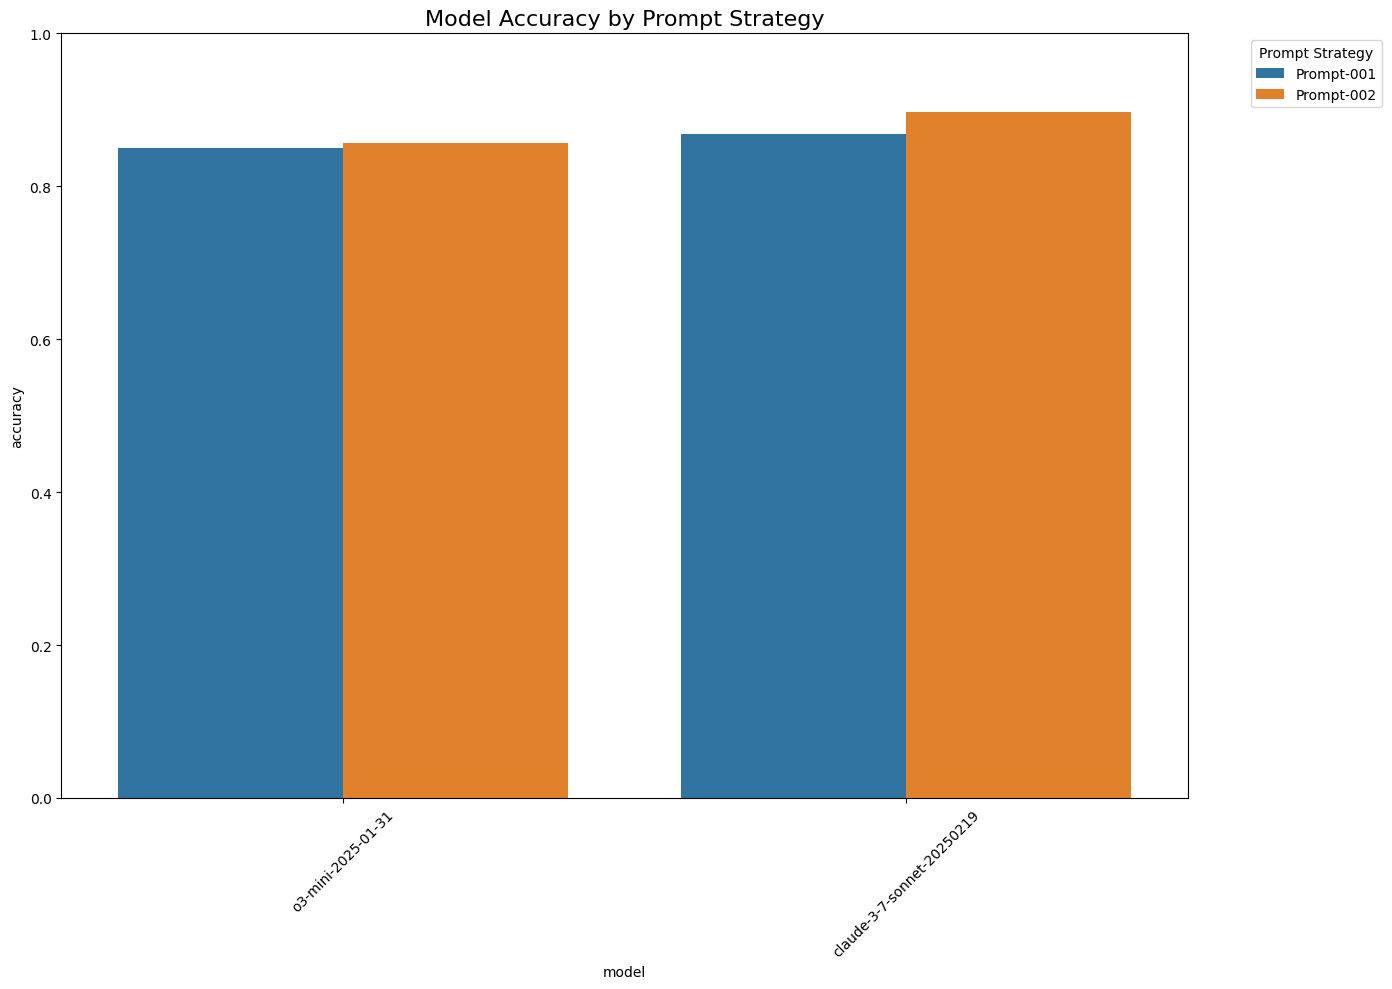

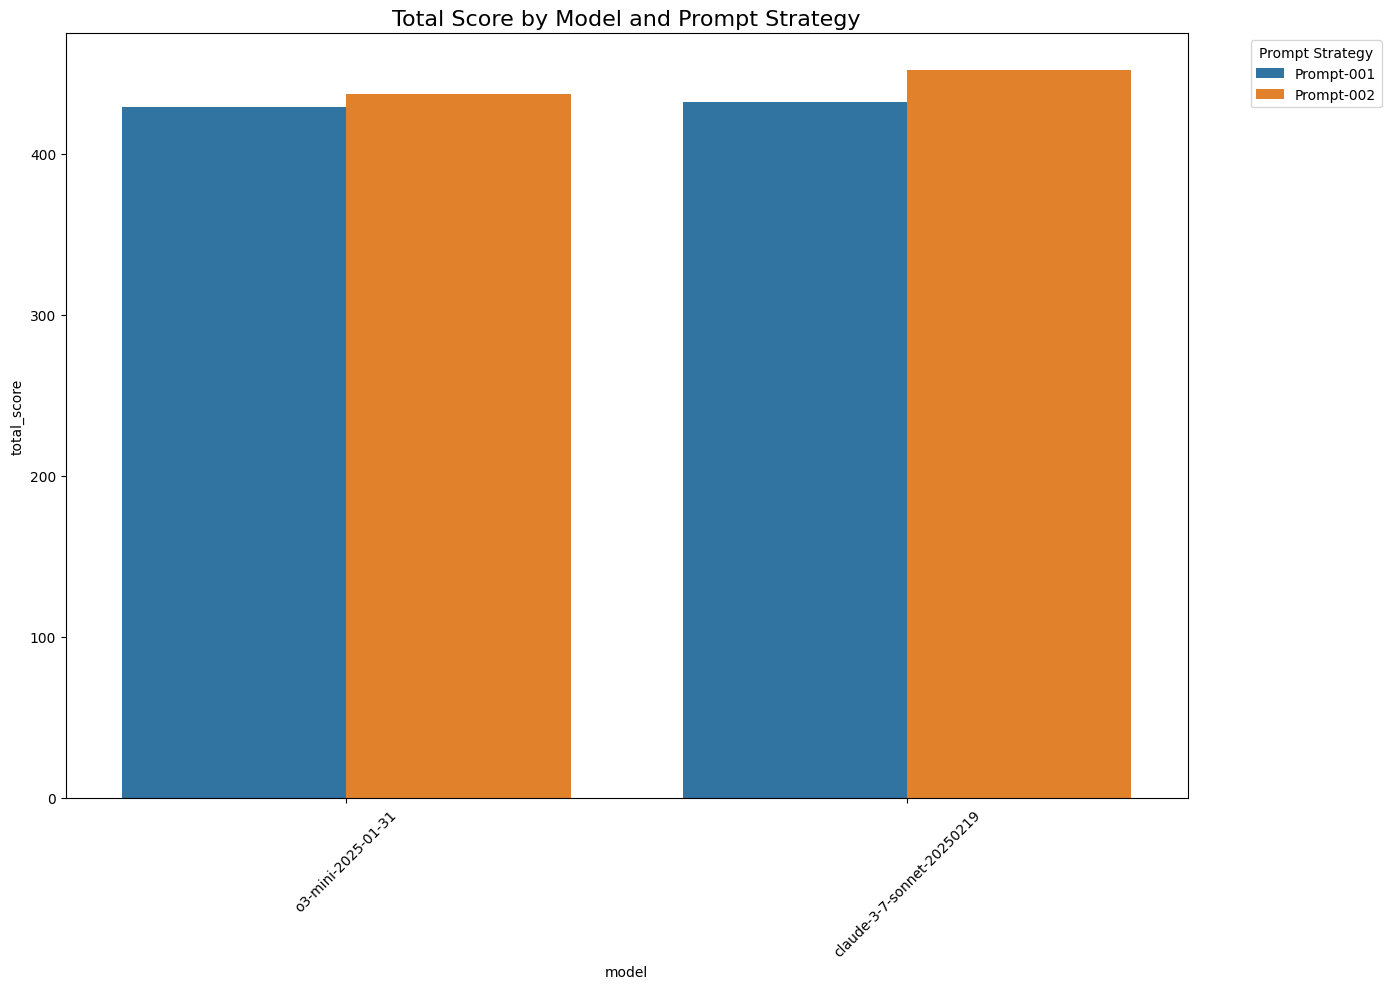


--- BEST PERFORMING COMBINATIONS ---
                        model prompt_strategy formatted_accuracy  total_score
3  claude-3-7-sonnet-20250219      Prompt-002             89.66%          452
2  claude-3-7-sonnet-20250219      Prompt-001             86.78%          432
1          o3-mini-2025-01-31      Prompt-002             85.63%          437
0          o3-mini-2025-01-31      Prompt-001             85.06%          429


In [9]:
# Cell 8: Analyze Results & Export Data for Tableau
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

def merge_results(result_files):
    """Merge evaluation summaries and details from all result files."""
    all_summaries = []
    all_details = []

    for file in result_files:
        try:
            with open(file, 'r') as f:
                results = json.load(f)
            # Append the summary (if available) and details from each evaluation
            all_summaries.append(results.get('summary', {}))
            all_details.extend(results.get('results', []))
        except Exception as e:
            print(f"Error processing {file}: {e}")
    return all_summaries, all_details

# If result_files is not available from Cell 7, search the results folder
if 'result_files' not in globals() or not result_files:
    result_dir = "data/results"
    result_files = [os.path.join(result_dir, f) for f in os.listdir(result_dir) if f.endswith("_results.json")]
    print(f"Found {len(result_files)} result files in {result_dir}")

# Merge the results from all evaluations
summaries, details = merge_results(result_files)

# Create pandas DataFrames for summaries and details
summary_df = pd.DataFrame(summaries)
details_df = pd.DataFrame(details)

# Prepare export directory and filenames with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
export_dir = "data/exports"
os.makedirs(export_dir, exist_ok=True)
summary_csv = os.path.join(export_dir, f"evaluation_summary_{timestamp}.csv")
details_csv = os.path.join(export_dir, f"evaluation_details_{timestamp}.csv")

# Export the dataframes to CSV for Tableau
summary_df.to_csv(summary_csv, index=False)
details_df.to_csv(details_csv, index=False)
print(f"✓ Exported evaluation summary to: {summary_csv}")
print(f"✓ Exported evaluation details to: {details_csv}")

# Create visualizations for model performance

# Visualization: Model Accuracy by Prompt Strategy
plt.figure(figsize=(14, 10))
sns.barplot(x='model', y='accuracy', hue='prompt_strategy', data=summary_df)
plt.title('Model Accuracy by Prompt Strategy', fontsize=16)
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(title='Prompt Strategy', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
accuracy_plot_path = os.path.join(export_dir, f"accuracy_comparison_{timestamp}.png")
plt.savefig(accuracy_plot_path, dpi=300)
plt.show()

# Visualization: Total Score by Model and Prompt Strategy
plt.figure(figsize=(14, 10))
sns.barplot(x='model', y='total_score', hue='prompt_strategy', data=summary_df)
plt.title('Total Score by Model and Prompt Strategy', fontsize=16)
plt.xticks(rotation=45)
plt.legend(title='Prompt Strategy', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
score_plot_path = os.path.join(export_dir, f"score_comparison_{timestamp}.png")
plt.savefig(score_plot_path, dpi=300)
plt.show()

# Display best performing combinations (top 5)
print("\n--- BEST PERFORMING COMBINATIONS ---")
summary_df['formatted_accuracy'] = summary_df['accuracy'].apply(lambda x: f"{x*100:.2f}%")
best_combos = summary_df.sort_values('accuracy', ascending=False)[['model', 'prompt_strategy', 'formatted_accuracy', 'total_score']].head(5)
print(best_combos)


✓ Exported evaluation summary to: data/exports/evaluation_summary_20250317_232059.csv
✓ Exported evaluation details to: data/exports/evaluation_details_20250317_232059.csv


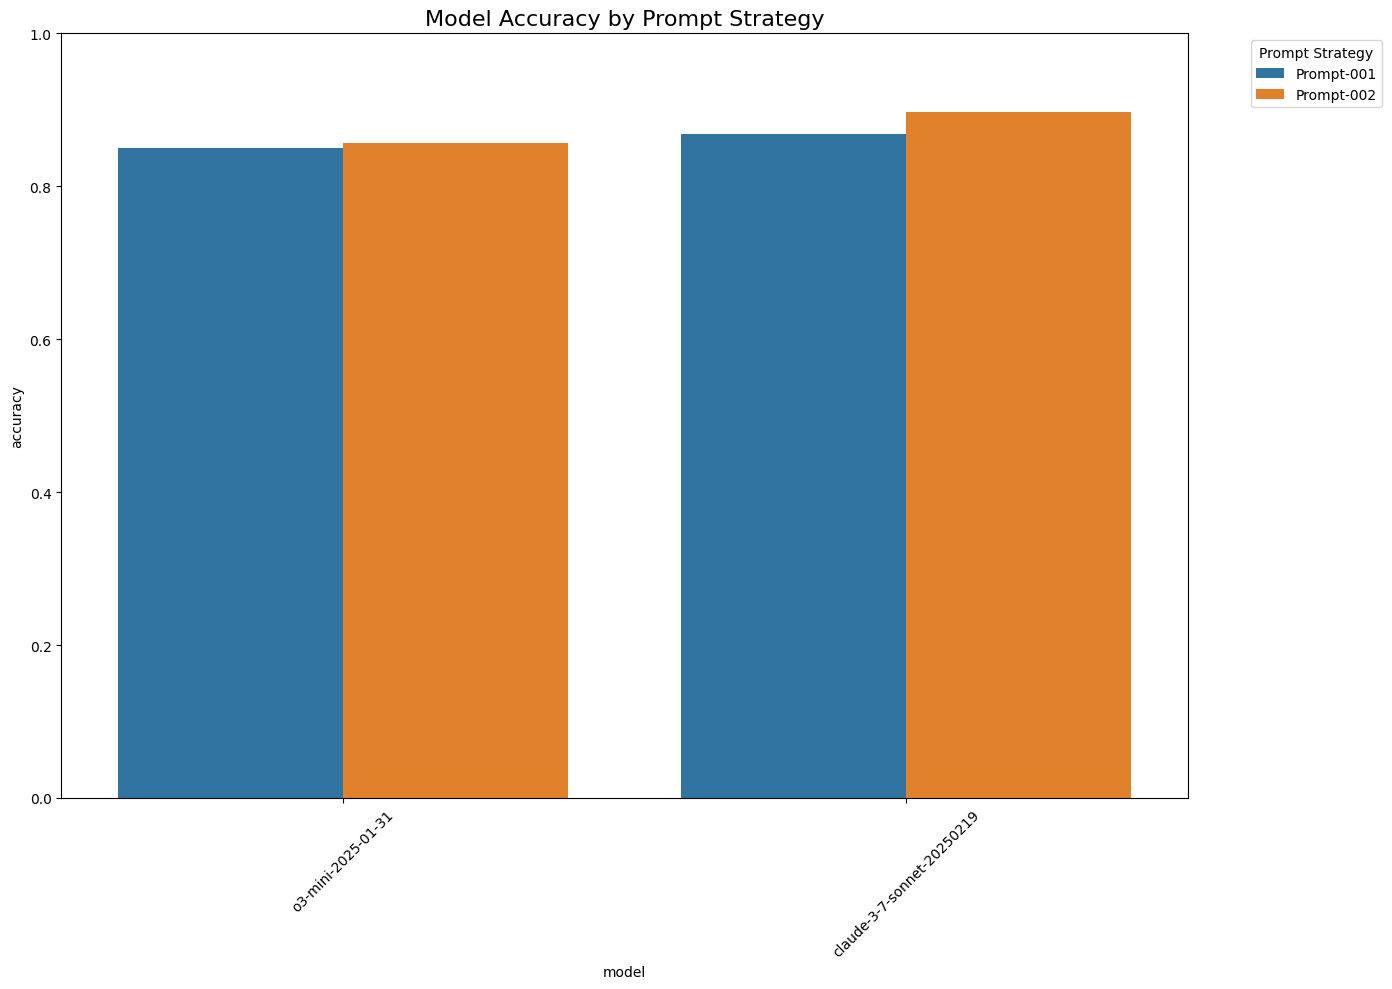

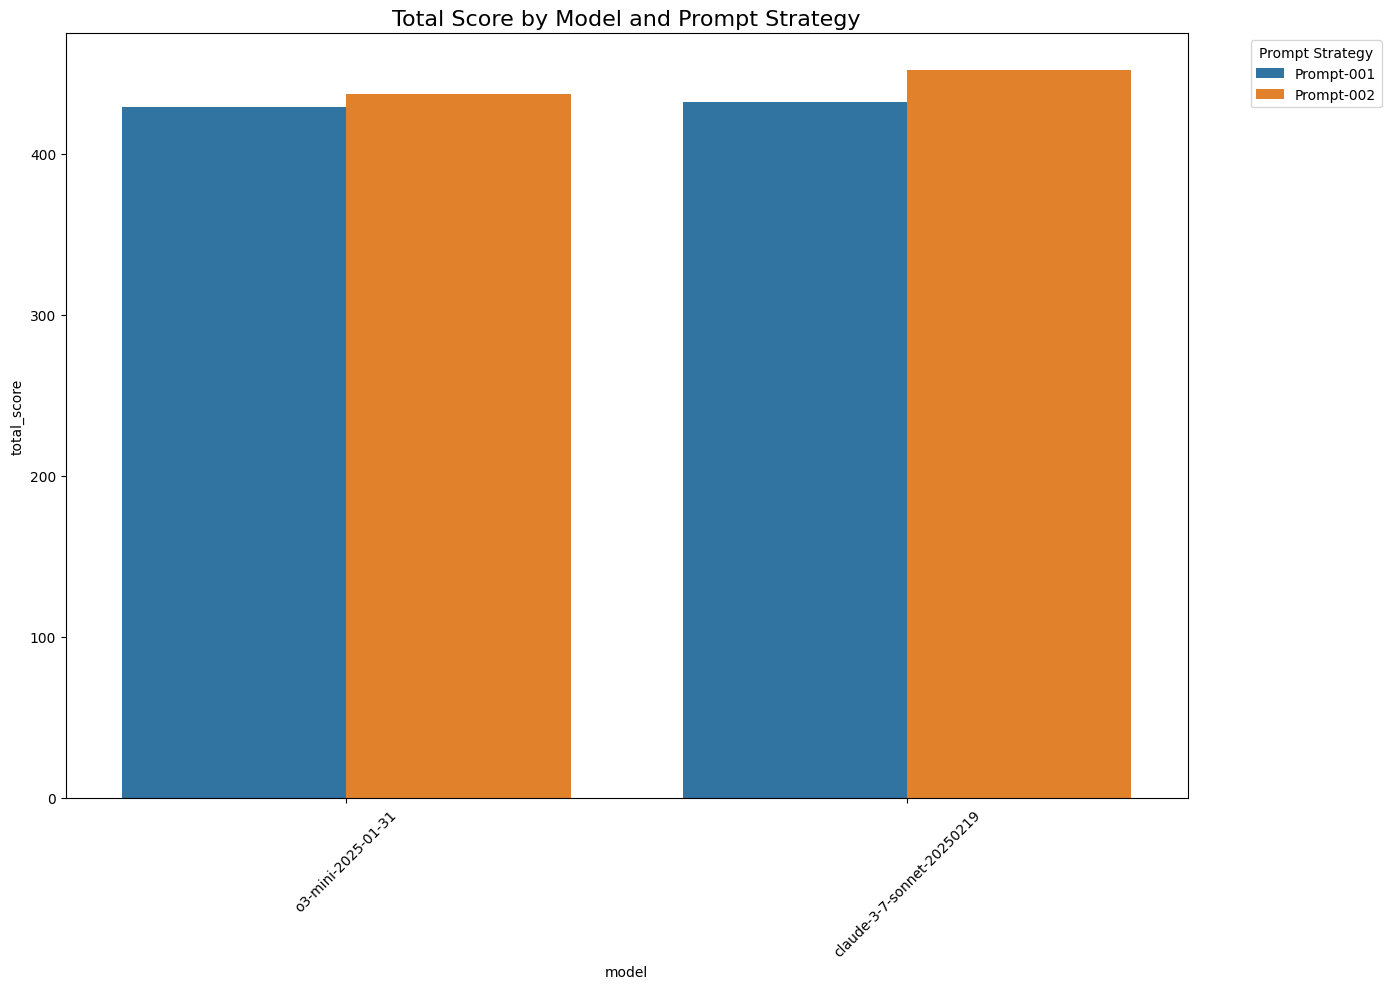


--- BEST PERFORMING COMBINATIONS ---
                        model prompt_strategy formatted_accuracy  total_score
3  claude-3-7-sonnet-20250219      Prompt-002             89.66%          452
2  claude-3-7-sonnet-20250219      Prompt-001             86.78%          432
1          o3-mini-2025-01-31      Prompt-002             85.63%          437
0          o3-mini-2025-01-31      Prompt-001             85.06%          429
✓ Results also exported to: data/results/prompting-strategy


In [10]:
# Cell 8: Analyze Results, Export Data for Tableau, and Export to GitHub Folder
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import shutil

def merge_results(result_files):
    """Merge evaluation summaries and details from all result files."""
    all_summaries = []
    all_details = []

    for file in result_files:
        try:
            with open(file, 'r') as f:
                results = json.load(f)
            all_summaries.append(results.get('summary', {}))
            all_details.extend(results.get('results', []))
        except Exception as e:
            print(f"Error processing {file}: {e}")
    return all_summaries, all_details

# If result_files is not available from Cell 7, search the results folder
if 'result_files' not in globals() or not result_files:
    result_dir = "data/results"
    result_files = [os.path.join(result_dir, f) for f in os.listdir(result_dir) if f.endswith("_results.json")]
    print(f"Found {len(result_files)} result files in {result_dir}")

# Merge the results from all evaluations
summaries, details = merge_results(result_files)
summary_df = pd.DataFrame(summaries)
details_df = pd.DataFrame(details)

# Prepare export directory and filenames with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
export_dir = "data/exports"
os.makedirs(export_dir, exist_ok=True)
summary_csv = os.path.join(export_dir, f"evaluation_summary_{timestamp}.csv")
details_csv = os.path.join(export_dir, f"evaluation_details_{timestamp}.csv")

# Export the dataframes to CSV for Tableau
summary_df.to_csv(summary_csv, index=False)
details_df.to_csv(details_csv, index=False)
print(f"✓ Exported evaluation summary to: {summary_csv}")
print(f"✓ Exported evaluation details to: {details_csv}")

# Create visualizations for model performance
plt.figure(figsize=(14, 10))
sns.barplot(x='model', y='accuracy', hue='prompt_strategy', data=summary_df)
plt.title('Model Accuracy by Prompt Strategy', fontsize=16)
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(title='Prompt Strategy', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
accuracy_plot_path = os.path.join(export_dir, f"accuracy_comparison_{timestamp}.png")
plt.savefig(accuracy_plot_path, dpi=300)
plt.show()

plt.figure(figsize=(14, 10))
sns.barplot(x='model', y='total_score', hue='prompt_strategy', data=summary_df)
plt.title('Total Score by Model and Prompt Strategy', fontsize=16)
plt.xticks(rotation=45)
plt.legend(title='Prompt Strategy', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
score_plot_path = os.path.join(export_dir, f"score_comparison_{timestamp}.png")
plt.savefig(score_plot_path, dpi=300)
plt.show()

print("\n--- BEST PERFORMING COMBINATIONS ---")
summary_df['formatted_accuracy'] = summary_df['accuracy'].apply(lambda x: f"{x*100:.2f}%")
best_combos = summary_df.sort_values('accuracy', ascending=False)[
    ['model', 'prompt_strategy', 'formatted_accuracy', 'total_score']
].head(5)
print(best_combos)

# Additionally, export the results to the GitHub folder: data/results/prompting-strategy/
github_export_dir = os.path.join("data", "results", "prompting-strategy")
os.makedirs(github_export_dir, exist_ok=True)

# Copy the JSON and CSV export files to the GitHub export folder
shutil.copy2(summary_csv, github_export_dir)
shutil.copy2(details_csv, github_export_dir)
shutil.copy2(accuracy_plot_path, github_export_dir)
shutil.copy2(score_plot_path, github_export_dir)

print(f"✓ Results also exported to: {github_export_dir}")


In [14]:
# Cell 9: Export Evaluation Results to GitHub (Copy files, commit, pull, and push)
from google.colab import userdata
import os
import shutil
import subprocess

# Step 1: Copy all evaluation files from data/results/ (excluding prompting-strategy folder) to data/results/prompting-strategy/
source_dir = "data/results"
target_dir = os.path.join(source_dir, "prompting-strategy")
os.makedirs(target_dir, exist_ok=True)

# Copy files with extensions .json, .csv, and .png (adjust as needed)
for filename in os.listdir(source_dir):
    if filename == "prompting-strategy":
        continue
    if filename.endswith(".json") or filename.endswith(".csv") or filename.endswith(".png"):
        src_path = os.path.join(source_dir, filename)
        dst_path = os.path.join(target_dir, filename)
        shutil.copy2(src_path, dst_path)
        print(f"Copied {src_path} to {dst_path}")

# Step 2: Push the updated results to GitHub using your GitHub token
try:
    # Retrieve GitHub token from Colab secrets
    github_token = userdata.get('GITHUB_TOKEN')
    if not github_token:
        raise ValueError("GITHUB_TOKEN is not set in Colab secrets.")

    # Define repository name and construct token URL
    repo_name = "armelida/MELIDA"
    token_url = f"https://{github_token}@github.com/{repo_name}.git"

    # Configure Git user details
    subprocess.run(["git", "config", "--global", "user.email", "armelida@gmail.com"], check=True)
    subprocess.run(["git", "config", "--global", "user.name", "Armelida"], check=True)

    # Update the remote URL to include the token
    subprocess.run(["git", "remote", "set-url", "origin", token_url], check=True)

    # Stage all changes (including the prompting-strategy folder)
    subprocess.run(["git", "add", "-A"], check=True)

    # Commit changes (if any). This command may fail if there is nothing to commit, so we ignore errors.
    commit_proc = subprocess.run(
        ["git", "commit", "-m", f"Auto commit evaluation results from $(date)"],
        capture_output=True,
        text=True
    )
    print("Git commit output:", commit_proc.stdout, commit_proc.stderr)

    # Pull the latest changes from the remote branch with rebase to integrate remote updates
    pull_proc = subprocess.run(
        ["git", "pull", "origin", "main", "--rebase"],
        capture_output=True,
        text=True,
        check=True
    )
    print("Git pull output:", pull_proc.stdout, pull_proc.stderr)

    # Push the committed changes to GitHub
    push_proc = subprocess.run(
        ["git", "push", "origin", "main"],
        capture_output=True,
        text=True,
        check=True
    )
    print("Git push output:", push_proc.stdout, push_proc.stderr)
    print("Results successfully pushed to GitHub")

except subprocess.CalledProcessError as cpe:
    print("Error during git operation:")
    print("Return code:", cpe.returncode)
    print("Output:", cpe.output)
    print("Error output:", cpe.stderr)
except Exception as e:
    print(f"Error pushing to GitHub: {e}")


Copied data/results/EVAL-MIR-2024-v01-t01-Prompt-001-o3-mini-2025-01-31-20250317-224252.csv to data/results/prompting-strategy/EVAL-MIR-2024-v01-t01-Prompt-001-o3-mini-2025-01-31-20250317-224252.csv
Copied data/results/EVAL-MIR-2024-v01-t01-Prompt-002-o3-mini-2025-01-31-20250317-230856.csv to data/results/prompting-strategy/EVAL-MIR-2024-v01-t01-Prompt-002-o3-mini-2025-01-31-20250317-230856.csv
Copied data/results/EVAL-MIR-2024-v01-t01-Prompt-001-claude-3-7-sonnet-20250219-20250317-231413.json to data/results/prompting-strategy/EVAL-MIR-2024-v01-t01-Prompt-001-claude-3-7-sonnet-20250219-20250317-231413.json
Copied data/results/EVAL-MIR-2024-v01-t01-Prompt-001-o3-mini-2025-01-31-20250317-224252.json to data/results/prompting-strategy/EVAL-MIR-2024-v01-t01-Prompt-001-o3-mini-2025-01-31-20250317-224252.json
Copied data/results/EVAL-MIR-2024-v01-t01-Prompt-001-claude-3-7-sonnet-20250219-20250317-224301.json to data/results/prompting-strategy/EVAL-MIR-2024-v01-t01-Prompt-001-claude-3-7-sonn